In [1]:
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings; warnings.simplefilter('ignore')
import pickle as pk
import pandas as pd
import ast
import os
from collections import defaultdict

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Load model checkpoint
# checkpoint = 'checkpoint_ssd300.pth.tar'
checkpoint = 'checkpoint_ssd300_experiment2.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

cuda

Loaded checkpoint from epoch 51.



In [3]:
labels = ('nilam', 'guava', 'sawo', 'taro','bamboo', 'coffeearabica','lychee','aroid','cinnamon',
             'mango','papaya','dragonfruit','vanilla','jackfruit','frangipani','sugarpalm','whitepepper',
             'snakefruit','waterguava','cacao','zodia','starfruit','passiflora','durian','mangosteen','banana')

label_map = {k: v + 1 for v, k in enumerate(labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                   '#ffd8b1', '#e6beff', '#808080', '#FFFFFF', '#FFFFFF', '#FFFFFF','#FFFFFF','#FFFFFF','#FFFFFF', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

In [4]:
def detect(original_image, min_score, max_overlap, top_k, image_name, data_label, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    data_label[image_name] = defaultdict(list)

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image
    
    
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        data_label[image_name][det_labels[i]].append(box_location)

#     return det_labels

#### Get annotated images

In [5]:
path = "../../data/bali-26/"
folders = os.listdir(path)

In [ ]:
for class_name in folders:

    data_label = dict()
    file_path = os.path.join(path,class_name)
    files = os.listdir(file_path)

    for image in files:
        if '.pk' in image:
            continue
        image_name = class_name + '_' + image
        img_path = os.path.join(file_path, image)
        original_image = Image.open(img_path, mode='r').convert('RGB')
        detect(original_image, min_score=0.05, max_overlap=0.5, top_k=200, image_name=image_name, data_label=data_label)
#         detection(file_path, image, data_label)
    
#     data_label_file_name = os.path.join(path, 'bootstrap_labels_exp1.pk')
#     with open(data_label_file_name, "wb") as f:
#         pk.dump(data_label, f)
    
    print (f"Class - {class_name} -> Detected_labels - {len(data_label)}")

Class - nilam -> Detected_labels - 1380
Class - guava -> Detected_labels - 2146
Class - sawo -> Detected_labels - 1358
Class - taro -> Detected_labels - 1765


In [5]:
# img_path = '/home/rts_azure/data/bali-26/cacao/1000.jpg'
# img_path = '/home/rts_azure/data/bali-26/mango/0184.jpg'
img_path = '/home/rts_azure/data/balimixedplants/taro_sawo.jpg'
original_image = Image.open(img_path, mode='r').convert('RGB')
# original_image = original_image
img, label = detect(original_image, min_score=0.05, max_overlap=0.5, top_k=200)

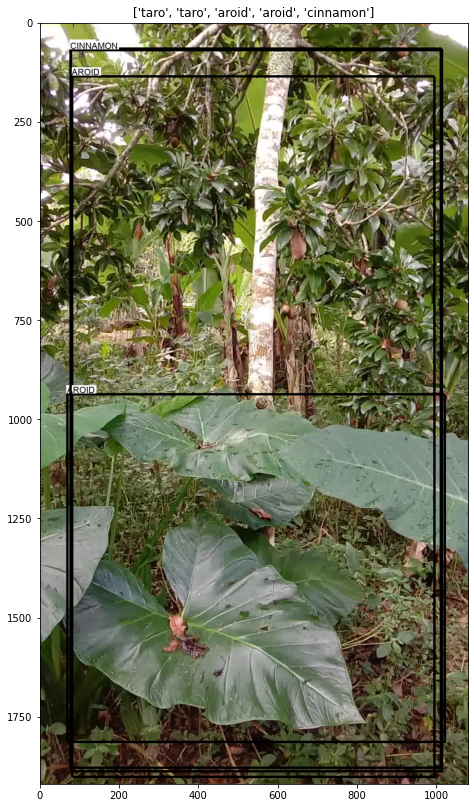

In [6]:
plt.figure(figsize=(14,14))
plt.title(label)
plt.imshow(img)

### Train evaluation

In [5]:
output_folder = os.path.abspath("../../data/training/")
with open(os.path.join(output_folder, 'TRAIN_images.json'), 'r') as j:
    images = json.load(j)
with open(os.path.join(output_folder, 'TRAIN_objects.json'), 'r') as j:
    objects = json.load(j)

In [15]:
assert(len(images) == len(objects))
labels = []
for i in tqdm(range(len(images))):
    img_path = images[i]
    original_image = Image.open(img_path, mode='r').convert('RGB')
    predicted_labels = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)
    original_labels = [rev_label_map[l] for l in objects[i]['labels']]
    
    labels.append((predicted_labels,original_labels))

100%|██████████| 19295/19295 [36:08<00:00,  8.90it/s]


In [5]:
# with open("predicted_labels.pk", 'wb') as f:
#     pk.dump(labels, f)
with open("predicted_labels.pk", 'rb') as f:
    test = pk.load(f)

In [6]:
df = pd.DataFrame(test, columns = ['predicted', 'true'])

In [8]:
df

,predicted,true
0,[nilam],[nilam]
1,[nilam],[nilam]
2,[nilam],[nilam]
3,[nilam],[nilam]
4,[nilam],[nilam]
...,...,...
19290,[banana],[banana]
19291,[banana],[banana]
19292,[banana],"[banana, banana]"
19293,[banana],[banana]


In [7]:
true_positives = 0
for idx, predicted, true in tqdm(df.itertuples()):
    if max(predicted) == max(true):
        true_positives += 1
#     if len(predicted) > 1:
#         print (predicted, true)
#         print (max(predicted))
#         break
print (true_positives / len(test))

19295it [00:00, 727040.83it/s]

0.9931588494428608


## Test Evaluation

In [5]:
from collections import Counter

In [12]:
# data_path = os.path.abspath("../../data/balimixedplants/")
data_path = os.path.abspath("../../data/bali-26/")
# accuracies = {}
predictions = []
for class_name in tqdm(os.listdir(data_path)):
    class_path = os.path.join(data_path, class_name)
    
#     class_positives = 0
#     total_class_images = 0
    for images in os.listdir(class_path):
        try:
            img_path = os.path.join(class_path, images)
            original_image = Image.open(img_path, mode='r').convert('RGB')
            predicted_labels = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)
    #             if max(predicted_labels) == class_name:
            predictions.append((predicted_labels,class_name))
#             if class_name in predicted_labels:
#                 class_positives += 1
#             total_class_images += 1

#             predictions.append((predicted_labels, images))
        except Exception as e:
            if '.pk' in images:
                pass
            else:
                print ("Error", images, e)
    #             print (images)
        
#     accuracy = class_positives / total_class_images
#     accuracies[class_name] = accuracy
#     print ("Class name: {}\nAccuracy: {}".format(class_name, accuracy), end='')
#     print ("---"*20, end ='\n')

100%|██████████| 26/26 [1:21:35<00:00, 188.29s/it]


In [31]:
# df.to_csv("test_predictions.csv", index=False)

In [6]:
df = pd.DataFrame(predictions, columns = ['predictions', 'true'])

NameError: name 'predictions' is not defined

In [7]:
df.head()

NameError: name 'df' is not defined

In [8]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer

In [9]:
df = pd.read_csv("test_predictions.csv")

df.head()

df.predictions = df.predictions.apply(ast.literal_eval)

In [18]:
t = df[df['true'] == 'nilam']

In [10]:
df.shape

(46230, 2)

In [11]:
mlb = MultiLabelBinarizer()
preds = mlb.fit_transform(df['predictions'])

In [12]:
mlb.classes_

array(['aroid', 'background', 'bamboo', 'banana', 'cacao', 'cinnamon',
       'coffeearabica', 'dragonfruit', 'durian', 'frangipani', 'guava',
       'jackfruit', 'lychee', 'mango', 'mangosteen', 'nilam', 'papaya',
       'passiflora', 'sawo', 'snakefruit', 'starfruit', 'sugarpalm',
       'taro', 'vanilla', 'waterguava', 'whitepepper', 'zodia'],
      dtype=object)

In [13]:
df['true1'] = df['true'].apply(lambda x: [x])

In [14]:
true = mlb.transform(df['true1'])

In [15]:
f1_score(preds, true, average='weighted')

0.8496146376044714

In [20]:
accuracies = {}
predictions = []
for class_name in os.listdir(data_path):
    if class_name != 'nilam':
        continue
    print (class_name)
    class_path = os.path.join(data_path, class_name)
    
    class_positives = 0
    total_class_images = 0
    for images in os.listdir(class_path):
        try:
            img_path = os.path.join(class_path, images)
            original_image = Image.open(img_path, mode='r').convert('RGB')
            predicted_labels = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)
#             if max(predicted_labels) == class_name:
            if class_name in predicted_labels:
                class_positives += 1
            total_class_images += 1
                
            predictions.append(predicted_labels)
        except Exception as e:
            if '.pk' in images:
                pass
            else:
                print ("Error", images, e)
#             print (images)
        
    accuracy = class_positives / total_class_images
    accuracies[class_name] = accuracy
    print ("Class name: {}\nAccuracy: {}".format(class_name, accuracy), end='')
    print ("---"*20, end ='\n')

cacao
Class name: cacao
Accuracy: 0.314071696094168------------------------------------------------------------


In [19]:
# max(Counter(predictions[1]))

'guava'

In [10]:
with open("accuracies.pk", 'wb') as f:
    pk.dump(accuracies, f)

NameError: name 'pk' is not defined

### Artificial Mixed plants testing

In [5]:
data_path = '/home/rts_azure/data/artificialmixedplants/'
images = os.listdir(data_path)

In [24]:
img_path = os.path.join(data_path, random.sample(images, 1)[0])
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
img, label = detect(original_image, min_score=0.05, max_overlap=0.5, top_k=200)

lychee_frangipani.jpg


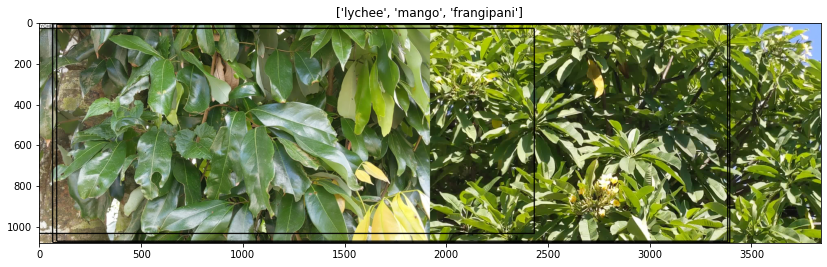

In [25]:
print (img_path.split("/")[-1])
plt.figure(figsize=(14,14))
plt.title(label)
plt.imshow(img)